# Preparation and Modeling
This notebook contains the Data Preparation and Modeling, as well as the Evaluation parts of the CRISP-DM framework.

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.pipelines import get_num_of_k
from src.utils import drop_missing_cols
from src.pipelines import LEncoder, variance_threshold_selector
from src.dataloader import  get_raw_data
from src.eval_metrics import eval_external_metrics, eval_internal_metrics

pd.set_option('display.float_format', lambda x: '%.3f' % x)

The output (figures) from this notebook can be found in the folder "cluster_output".

In [2]:
import os
script_dir = os.path.dirname('')
results_dir = os.path.join(script_dir, 'cluster_output/')
os.makedirs(results_dir, exist_ok=True)

In [3]:

cats = [
    'DMSEX',
    #'PHNYHA', 
    'PHSYNA', 'PHCARPYN', 
    'PHSPIYN','PHPERFYN', #'PHOTHYN',
    'PHMH2', 'PHMH6', 'PHMH7', 'PHMH8', 'PHMH9','PHMH10',
    'EKGVOLT', 'DUOTHBIYN',
    'DPD'
]

conts = [
    'DMAGE',
    'ECHLVIDD', #'ECHLVIDS',
    'ECHIVSD', 'ECHLVPW',
    #'ECHLADIA',
    'ECHLAAR', #'ECHLAVOL', 
    'ECHEJFR', 
    #'ECHEA',
    'HEKRRE', 'HEGFRRE', 'HEBNPRE', 'HETNTRE',
    'K/L Ratio'
]

## Data Preparation

In [4]:
from sklearn.model_selection import train_test_split

data = get_raw_data(dataset='./data/data_v2.xlsx', sheet_name='Data')
data = drop_missing_cols(data, 40)

X = data.copy()
X[cats] = X[cats].fillna('Ukjent')
X[cats] = X[cats].astype(str)
y = data.PHDIAG

X, X_test, y, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

y_ca = y.replace('TTR amyloidose', 'CA')
y_ca = y_ca.replace('AL amyloidose', 'CA')
y_ca = y_ca.replace('Annet', 'non-CA')

y_ca_test = y_test.replace('TTR amyloidose', 'CA')
y_ca_test = y_test.replace('AL amyloidose', 'CA')
y_ca_test = y_test.replace('Annet', 'non-CA')

### Feature Engineering

In [5]:
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import MinMaxScaler

# Training set
### Continuous

# Imputation
imputer = IterativeImputer(BayesianRidge())#, initial_strategy='median', random_state=0)
imputer.fit(X[conts])
impute_data = pd.DataFrame(imputer.transform(X[conts]), index=X.index, columns=conts)

'''
cont_feature_eng = make_pipeline(
    IterativeImputer(BayesianRidge(), initial_strategy='median', random_state=0),
    MinMaxScaler(),
)
'''

# Normalization
normalizer = MinMaxScaler()
normalizer.fit(impute_data)
normalized = pd.DataFrame(normalizer.transform(impute_data), index=X.index, columns=conts)

# Feature engineering by variance threshold
conts_high_variance = variance_threshold_selector(normalized, .99 * (1 - .99))
post_hv_conts = conts_high_variance.columns

### Categorical
le = LEncoder()
encoded = le.fit_transform(X[cats])

'''
cat_feature_eng = make_pipeline(
    LEncode(),
)
'''

# Feature engineering by variance threshold
cats_high_variance = variance_threshold_selector(encoded, .75 * (1 - .75))
inverse_cats = le.inverse_transform(cats_high_variance)
post_hv_cats = inverse_cats.columns

new_cats = [*inverse_cats.columns]
new_conts = [*conts_high_variance.columns]

updated_data = pd.concat([conts_high_variance, inverse_cats], axis=1)
cat_cols = list(updated_data.columns.get_indexer(new_cats))

In [6]:
print(len(post_hv_conts))
print(len(conts))

print(len(post_hv_cats))
print(len(cats))

9
11
7
14


### Summary of features after Feature Selection and Engineering

#### Continuous features

In [7]:
updated_data.describe().T

,count,mean,std,min,25%,50%,75%,max
DMAGE,154.000,0.642,0.221,0.000,0.547,0.695,0.780,1.000
ECHIVSD,154.000,0.429,0.164,0.000,0.304,0.435,0.565,1.000
ECHLVPW,154.000,0.442,0.173,0.000,0.353,0.433,0.529,1.000
ECHLAAR,154.000,0.352,0.141,0.000,0.293,0.352,0.366,1.000
ECHEJFR,154.000,0.537,0.189,0.000,0.481,0.567,0.633,1.000
HEKRRE,154.000,0.112,0.125,0.000,0.062,0.082,0.116,1.000
HEGFRRE,154.000,0.543,0.209,0.000,0.406,0.555,0.661,1.000
HEBNPRE,154.000,0.115,0.182,0.000,0.020,0.058,0.128,1.000
HETNTRE,154.000,0.051,0.132,0.000,0.008,0.022,0.045,1.000


#### Categorical features

In [8]:
updated_data.describe(include='object').T

,count,unique,top,freq
DMSEX,154,2,Mann,113
PHPERFYN,154,3,Nei,99
PHMH2,154,2,Ukjent,83
PHMH6,154,2,Ukjent,108
PHMH7,154,2,Ukjent,96
EKGVOLT,154,3,Nei,123
DPD,154,6,Normal,48


In [9]:
updated_data.groupby(['PHPERFYN']).count().T

PHPERFYN,Ja,Nei,Ukjent
DMAGE,48,99,7
ECHIVSD,48,99,7
ECHLVPW,48,99,7
ECHLAAR,48,99,7
ECHEJFR,48,99,7
HEKRRE,48,99,7
HEGFRRE,48,99,7
HEBNPRE,48,99,7
HETNTRE,48,99,7
DMSEX,48,99,7


In [10]:
updated_data.groupby(['EKGVOLT']).count().T

EKGVOLT,Ja,Nei,Ukjent
DMAGE,24,123,7
ECHIVSD,24,123,7
ECHLVPW,24,123,7
ECHLAAR,24,123,7
ECHEJFR,24,123,7
HEKRRE,24,123,7
HEGFRRE,24,123,7
HEBNPRE,24,123,7
HETNTRE,24,123,7
DMSEX,24,123,7


In [11]:
updated_data.groupby(['DPD']).count().T

DPD,1.0,2.0,3.0,Ikke testet,Normal,"Patologisk, uten grad"
DMAGE,6,23,32,36,48,9
ECHIVSD,6,23,32,36,48,9
ECHLVPW,6,23,32,36,48,9
ECHLAAR,6,23,32,36,48,9
ECHEJFR,6,23,32,36,48,9
HEKRRE,6,23,32,36,48,9
HEGFRRE,6,23,32,36,48,9
HEBNPRE,6,23,32,36,48,9
HETNTRE,6,23,32,36,48,9
DMSEX,6,23,32,36,48,9


#### Test set

In [12]:
# Test set, here we only transform 
impute_data_test = pd.DataFrame(imputer.transform(X_test[conts]), index=X_test.index, columns=conts)
normalized_test = pd.DataFrame(normalizer.transform(impute_data_test), index=X_test.index, columns=conts)
conts_hv_test = normalized_test[post_hv_conts]

cat_cols_test = X_test[post_hv_cats]

new_cats_test = [*cat_cols_test.columns]
new_conts_test = [*conts_hv_test.columns]

updated_data_test = pd.concat([conts_hv_test, cat_cols_test], axis=1)
cat_cols_test = list(updated_data_test.columns.get_indexer(new_cats_test))

## (Dis)similarity measure & Dimension reduction

#### Dissimilarity measure
Calculate Gower distance for the data set

In [13]:
import gower
from sklearn.manifold import TSNE

gd = gower.gower_matrix(updated_data)
gd_test = gower.gower_matrix(updated_data_test)

#### Dimension reduction
Apply t-SNE to the Gower distances

In [14]:
gow_tsne = TSNE(n_components=2, perplexity=30, random_state=0).fit_transform(gd)
gow_tsne_test = TSNE(n_components=2, perplexity=30, random_state=0).fit_transform(gd_test)

/opt/homebrew/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Apply FAMD to the data set (not the Gower distances)

In [15]:
import prince

famd = prince.FAMD(n_components=2, n_iter=10,
                   copy=True, check_input=True,
                   engine='auto',random_state=0)

famd = famd.fit(updated_data)
famd_transformed = famd.row_coordinates(updated_data)
famd_transformed_test = famd.row_coordinates(updated_data_test)

### Parameter Selection
In the part below, we select the number of k clusters. Following the Elbow method, we calculate an estimated number of k for the Gower distances and FAMD data sets. We select the mean of the two.

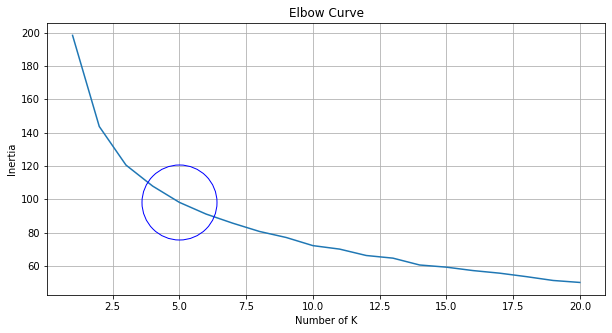

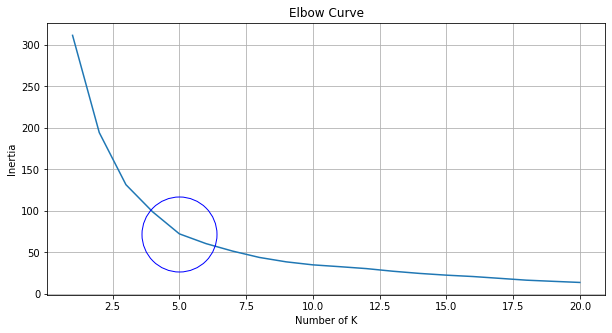

In [16]:
k1 = get_num_of_k(gd, os.path.join(results_dir, 'gower'))
k2 = get_num_of_k(famd_transformed, os.path.join(results_dir, 'famd'))

In [17]:
import math

num_k = math.ceil((max(k1, k2) + min(k1, k2))/2)

In [18]:
num_k

5

#### Calculate epsilon for DBSCAN
The epsilon we select for DBSCAN is the value where the y-axis is the steepest.

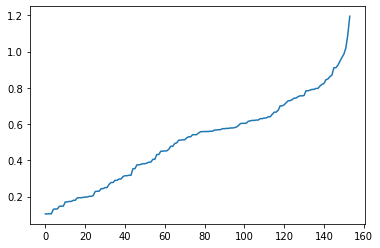

In [19]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(gd)

distances, indices = nbrs.kneighbors(gd)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.plot(distances)

## Modeling
In this part, we do the modeling for thesis. K-prototype clustering, K-means clustering, Agglomerative hierarchical clustering, DBSCAN, and OPTICS are implemented.

In [20]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS
from kmodes.kprototypes import KPrototypes

models = [
    KPrototypes(n_clusters=num_k, max_iter=500, n_init=15, random_state=0),
    KMeans(n_clusters=num_k, init="k-means++", n_init=15, max_iter=500, random_state=0),
    AgglomerativeClustering(n_clusters=num_k, affinity='precomputed', linkage='complete'),
    DBSCAN(eps=0.8, metric='precomputed', min_samples=5),
    OPTICS(metric='precomputed', min_samples=5)
]

#### K-prototypes clustering

In [21]:
cols_mask = new_cats+new_conts+['PHDIAG']

kproto_data = X.copy()[cols_mask]
kproto_test = X_test.copy()[cols_mask]

kproto = models[0]
kproto_preds = kproto.fit_predict(updated_data, categorical=cat_cols)
kproto_data['Clusters'] = kproto_preds
kproto_test['Clusters'] = kproto.predict(updated_data_test, categorical=cat_cols)

#### K-means clustering

In [22]:
kmeans_data = X.copy()[cols_mask]
kmeans_test = X_test.copy()[cols_mask]

kmeans = models[1]
kmeans.fit(famd_transformed)
kmeans_preds = kmeans.predict(famd_transformed)
kmeans_data['Clusters'] = kmeans_preds
kmeans_test['Clusters'] = kmeans.predict(famd_transformed_test)

#### Agglomerative hierarchical clustering

In [23]:
agglo_data = X.copy()[cols_mask]
agglo_test = X_test.copy()[cols_mask]

agglo = models[2]
agglo_preds = agglo.fit_predict(gd)
agglo_data['Clusters'] = agglo_preds
agglo_test['Clusters'] = agglo.fit_predict(gd_test)

#### DBSCAN

In [24]:
dbscan_data = X.copy()[cols_mask]

dbsc = models[3]
dbsc_preds = dbsc.fit_predict(gd)
dbscan_data['Clusters'] = dbsc_preds

#### OPTICS

In [25]:
optics_data = X.copy()[cols_mask]

opt = models[-1]
opt_preds = opt.fit_predict(gd)
optics_data['Clusters'] = opt_preds

## Results and Evaluation

In [26]:
from src.utils import summarize_clusters
from sklearn.ensemble import RandomForestClassifier

#### K-prototypes clustering
The plot below presents the clustering output in 2D using FAMD. 

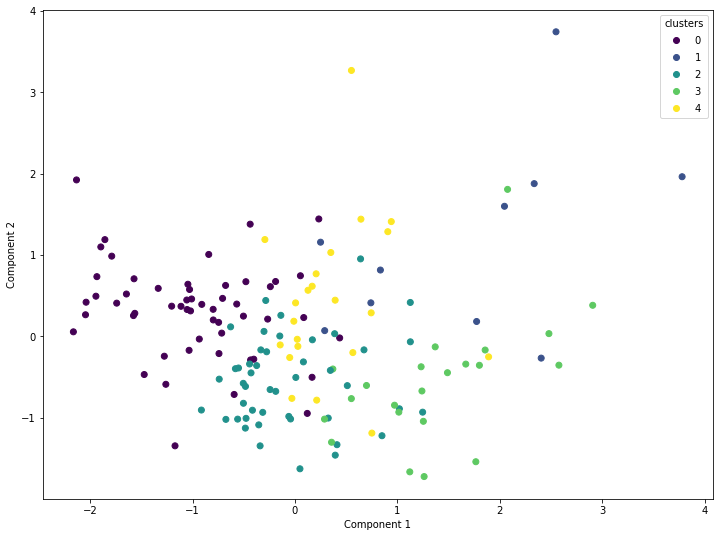

In [27]:
fig = plt.figure(figsize=(12, 9))
sc = plt.scatter(famd_transformed[0], famd_transformed[1], c=kproto_preds)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(*sc.legend_elements(), title='clusters')

plt.savefig(os.path.join(results_dir, 'gower_kproto_plot'))
plt.show()

In [28]:
summarize_clusters(kproto_data)

/Users/jmriiser/Dev/master_thesis/data_mining_prac/src/utils.py:95: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  [data.groupby(['Clusters']).get_group(i).median().T,
/Users/jmriiser/Dev/master_thesis/data_mining_prac/src/utils.py:95: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  [data.groupby(['Clusters']).get_group(i).median().T,
/Users/jmriiser/Dev/master_thesis/data_mining_prac/src/utils.py:95: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  [data.groupby(['Clusters']).get_group(i).m

,0,1,2,3,4
DMAGE,61.000,74.500,76.000,79.000,74.000
ECHIVSD,1.500,1.250,1.350,1.700,1.500
ECHLVPW,1.050,1.200,0.900,1.400,1.400
ECHLAAR,25.000,27.000,29.000,31.000,23.500
ECHEJFR,55.000,30.000,55.000,34.000,45.000
HEKRRE,79.000,108.000,95.000,117.000,117.000
HEGFRRE,84.000,44.000,62.500,55.500,51.000
HEBNPRE,758.000,19323.000,1917.500,6187.000,2740.000
HETNTRE,17.500,96.000,42.000,74.500,45.000
Clusters,0.000,1.000,2.000,3.000,4.000


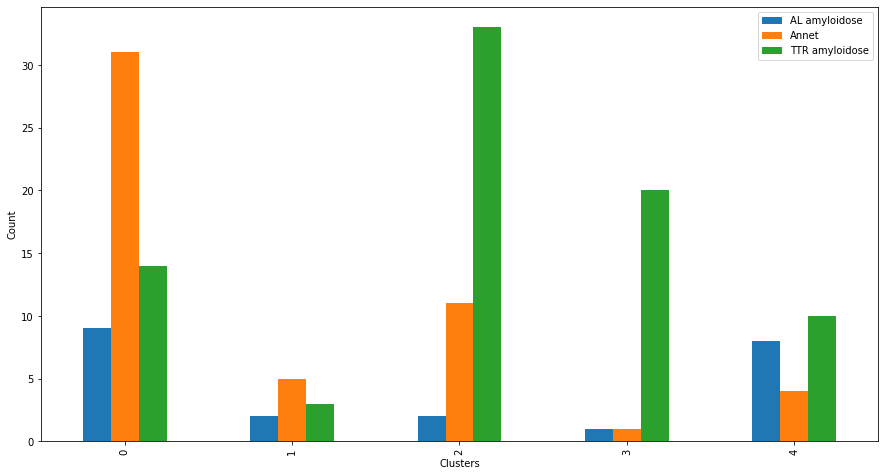

In [29]:
data_counts = pd.DataFrame(kproto_data.groupby(['Clusters', 'PHDIAG']).size()).unstack(fill_value=0)
data_counts.plot(kind='bar',figsize=(15, 8), xlabel='Clusters', ylabel='Count')
plt.legend(['AL amyloidose', 'Annet', 'TTR amyloidose'])

plt.savefig(os.path.join(results_dir, 'kproto_clusters'))

In [30]:
kproto_data.groupby(['Clusters', 'PHDIAG']).count().DMSEX, kproto_data.groupby(['Clusters', 'DPD']).count().DMSEX

(Clusters  PHDIAG        
 0         AL amyloidose      9
           Annet             31
           TTR amyloidose    14
 1         AL amyloidose      2
           Annet              5
           TTR amyloidose     3
 2         AL amyloidose      2
           Annet             11
           TTR amyloidose    33
 3         AL amyloidose      1
           Annet              1
           TTR amyloidose    20
 4         AL amyloidose      8
           Annet              4
           TTR amyloidose    10
 Name: DMSEX, dtype: int64,
 Clusters  DPD                  
 0         2.0                       7
           3.0                       6
           Ikke testet               8
           Normal                   32
           Patologisk, uten grad     1
 1         2.0                       1
           Ikke testet               2
           Normal                    5
           Patologisk, uten grad     2
 2         1.0                       6
           2.0                       3
    

In [31]:
kproto_data.groupby(['Clusters']).describe(include='object').T

Clusters              0            1               2               3  \
DMSEX    count       54           10              46              22   
         unique       2            2               2               2   
         top       Mann       Kvinne            Mann            Mann   
         freq        35            7              39              20   
PHPERFYN count       54           10              46              22   
         unique       3            2               3               3   
         top        Nei           Ja             Nei              Ja   
         freq        48            8              37              18   
PHMH2    count       54           10              46              22   
         unique       2            2               2               2   
         top     Ukjent       Ukjent    Atrieflimmer    Atrieflimmer   
         freq        47            7              41              18   
PHMH6    count       54           10              46              22   
         unique       2            2               2               2   
         top     Ukjent  Hjertesvikt          Ukjent     Hjertesvikt   
         freq        42            7              37              16   
PHMH7    count       54           10              46              22   
         unique       2            2               2               2   
         top     Ukjent    Hypertoni       Hypertoni          Ukjent   
         freq        44            9              28              16   
EKGVOLT  count       54           10              46              22   
         unique       3            2               2               3   
         top        Nei          Nei             Nei             Nei   
         freq        48            9              36              13   
DPD      count       54           10              46              22   
         unique       5            4               6               5   
         top     Normal       Normal             3.0             2.0   
         freq        32            5              21              10   
PHDIAG   count       54           10              46              22   
         unique       3            3               3               3   
         top      Annet        Annet  TTR amyloidose  TTR amyloidose   
         freq        31            5              33              20   

Clusters                      4  
DMSEX    count               22  
         unique               2  
         top               Mann  
         freq                16  
PHPERFYN count               22  
         unique               3  
         top                 Ja  
         freq                11  
PHMH2    count               22  
         unique               2  
         top             Ukjent  
         freq                20  
PHMH6    count               22  
         unique               2  
         top             Ukjent  
         freq                20  
PHMH7    count               22  
         unique               2  
         top             Ukjent  
         freq                17  
EKGVOLT  count               22  
         unique               3  
         top                Nei  
         freq                17  
DPD      count               22  
         unique               5  
         top        Ikke testet  
         freq                14  
PHDIAG   count               22  
         unique               3  
         top     TTR amyloidose  
         freq                10

Validation scores

In [32]:
eval_external_metrics(kproto_data, y, y_ca, num_k)
eval_internal_metrics(famd_transformed, kproto_data.Clusters)

Accuracy Score: 0.643
Recall Score: 0.643
Precision Score: 0.554
F1 Score: 0.595
CA/non-CA
Accuracy Score : 0.714
Recall Score: 0.714
Precision Score: 0.717
F1 Score : 0.716
Silhouette Score: 0.144
Calinski Harabasz Score: 44.648
Davies Bouldin Score: 1.400


/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.14370398601282083, 44.647955394151104, 1.400491883745171)

#### Feature importance

In [33]:
def result_transformer(data):
    data_dict = {}
    for i in range(num_k):
        data_dict[i] = data.copy()
        data_dict[i]['Clusters'] = data_dict[i]['Clusters'].map(lambda c: 1 if c == i else 0)
    return data_dict

In [34]:
train_data = updated_data.copy()
le = LEncoder()
train_data[new_cats] = le.fit_transform(train_data[new_cats])

transformed_clusters = result_transformer(kproto_data)

df = pd.DataFrame([['A', 10, 20, 10, 30], ['B', 20, 25, 15, 25], ['C', 12, 15, 19, 6],
                   ['D', 10, 29, 13, 19]],
                  columns=['Team', 'Round 1', 'Round 2', 'Round 3', 'Round 4'])
# view data
feats = []
weights = []
for i in range(len(transformed_clusters)):
    clf = RandomForestClassifier(random_state=0)
    clf.fit(train_data, transformed_clusters[i].Clusters)

    sorted_most_imp = np.argsort(clf.feature_importances_)[::-1]

    feats.append(np.take_along_axis(
        np.array(train_data.iloc[:, :].columns.tolist()),
        sorted_most_imp, axis=0
    ))

    weights.append(np.take_along_axis(
        np.array(clf.feature_importances_),
        sorted_most_imp, axis=0
    ))

In [35]:
df_dict = dict(zip(feats[0], [[] for _ in range(len((feats[0])))]))

for feat, we in zip(feats, weights):
    for f, w in zip(feat, we):
        df_dict[f].append(w)

eeete=[]
for k in df_dict.keys():
    eeete.append([k, *df_dict[k]])

ft_imp = pd.DataFrame(eeete, columns=['Features', 'Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])

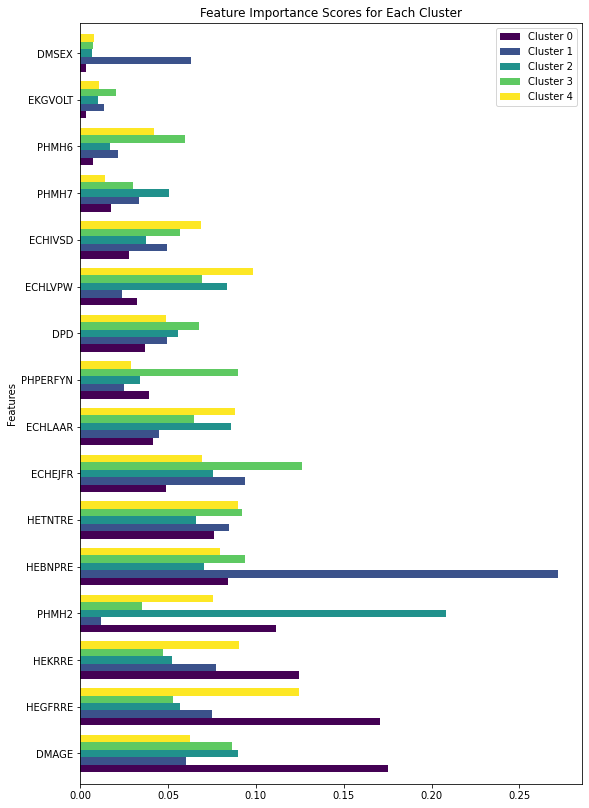

In [36]:
ft_imp.plot(
    x='Features',
    kind='barh',
    stacked=False,
    figsize=(9, 14),
    xlabel='Features',
    ylabel='Scores',
    width=0.8,
    colormap='viridis',
    title='Feature Importance Scores for Each Cluster'
)
plt.savefig(os.path.join(results_dir, 'feature_importances'))

#### K-means clustering

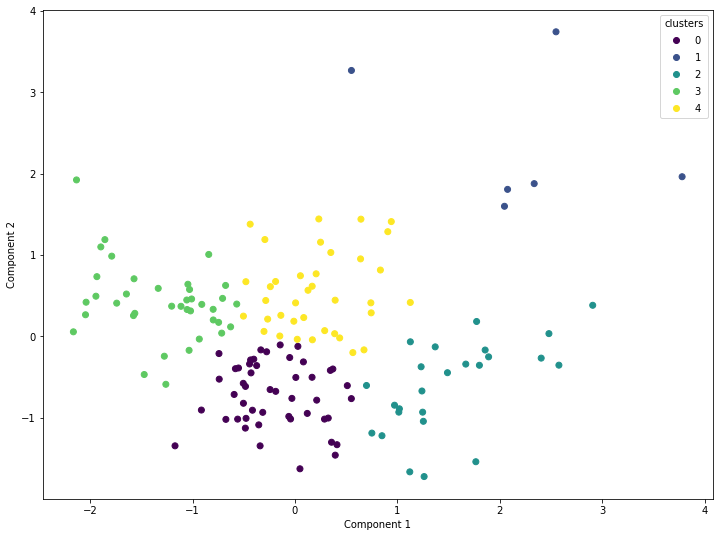

In [37]:
fig = plt.figure(figsize=(12, 9))
sc = plt.scatter(famd_transformed[ 0], famd_transformed[1], c=kmeans_preds)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(*sc.legend_elements(), title='clusters')
plt.savefig(os.path.join(results_dir, 'gower_kmeans_plot'))
plt.show()

In [38]:
summarize_clusters(kmeans_data)

/Users/jmriiser/Dev/master_thesis/data_mining_prac/src/utils.py:95: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  [data.groupby(['Clusters']).get_group(i).median().T,
/Users/jmriiser/Dev/master_thesis/data_mining_prac/src/utils.py:95: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  [data.groupby(['Clusters']).get_group(i).median().T,
/Users/jmriiser/Dev/master_thesis/data_mining_prac/src/utils.py:95: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  [data.groupby(['Clusters']).get_group(i).m

,0,1,2,3,4
DMAGE,75.500,69.000,82.000,56.000,72.000
ECHIVSD,1.500,1.250,1.650,1.200,1.450
ECHLVPW,1.100,1.200,1.500,1.000,1.100
ECHLAAR,30.500,24.000,31.000,24.000,24.000
ECHEJFR,50.500,44.000,34.500,55.000,50.000
HEKRRE,92.000,397.000,117.500,79.000,112.000
HEGFRRE,68.000,15.500,51.000,88.000,51.000
HEBNPRE,1346.000,35000.000,6687.000,493.500,2780.000
HETNTRE,42.000,232.500,71.000,17.000,44.000
Clusters,0.000,1.000,2.000,3.000,4.000


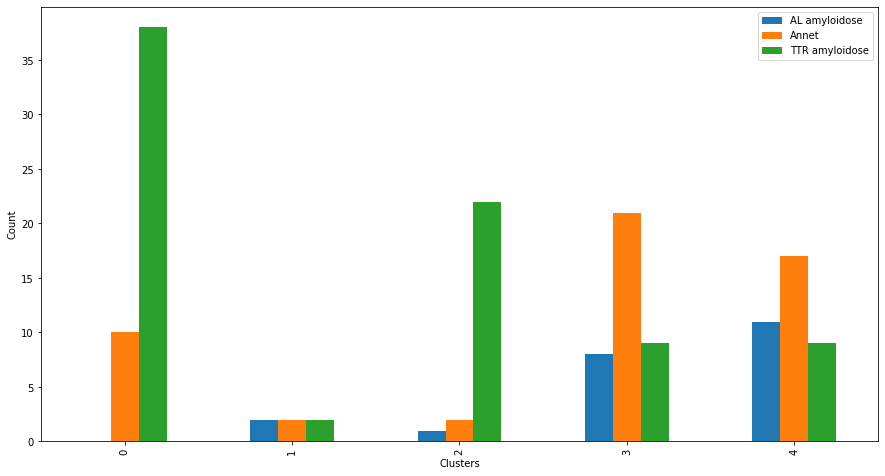

In [39]:
data_counts = pd.DataFrame(kmeans_data.groupby(['Clusters', 'PHDIAG']).size()).unstack(fill_value=0)
data_counts.plot(kind='bar',figsize=(15, 8), xlabel='Clusters', ylabel='Count')
plt.legend(['AL amyloidose', 'Annet', 'TTR amyloidose'])
plt.savefig(os.path.join(results_dir, 'kmeans_clusters'))

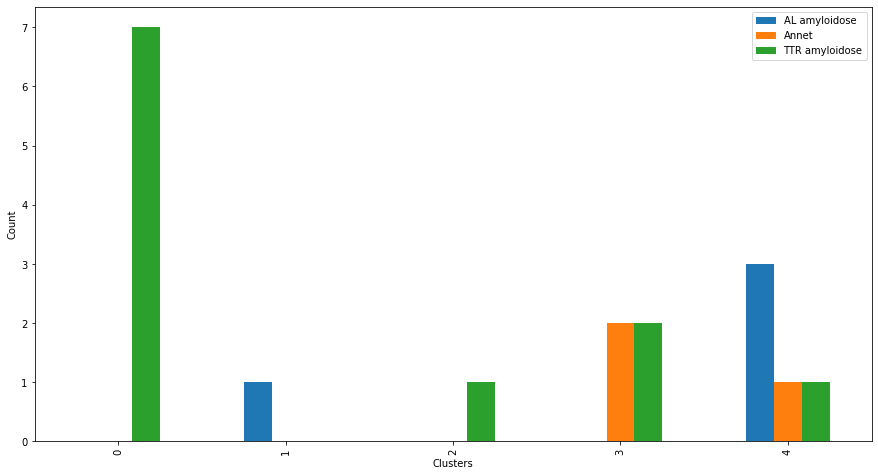

In [40]:
data_counts = pd.DataFrame(kmeans_test.groupby(['Clusters', 'PHDIAG']).size()).unstack(fill_value=0)
data_counts.plot(kind='bar',figsize=(15, 8), xlabel='Clusters', ylabel='Count')
plt.legend(['AL amyloidose', 'Annet', 'TTR amyloidose'])
plt.savefig(os.path.join(results_dir, 'kmeans_clusters_test'))

In [41]:
kmeans_data.groupby(['Clusters', 'PHDIAG']).count().DMSEX, kmeans_data.groupby(['Clusters', 'DPD']).count().DMSEX

(Clusters  PHDIAG        
 0         Annet             10
           TTR amyloidose    38
 1         AL amyloidose      2
           Annet              2
           TTR amyloidose     2
 2         AL amyloidose      1
           Annet              2
           TTR amyloidose    22
 3         AL amyloidose      8
           Annet             21
           TTR amyloidose     9
 4         AL amyloidose     11
           Annet             17
           TTR amyloidose     9
 Name: DMSEX, dtype: int64,
 Clusters  DPD                  
 0         1.0                       5
           2.0                       6
           3.0                      23
           Ikke testet               9
           Normal                    4
           Patologisk, uten grad     1
 1         2.0                       2
           Ikke testet               3
           Normal                    1
 2         2.0                       7
           3.0                       5
           Ikke testet              

In [42]:
kmeans_data.groupby(['Clusters']).describe(include='object').T

Clusters                      0               1               2       3  \
DMSEX    count               48               6              25      38   
         unique               2               2               2       2   
         top               Mann            Mann            Mann    Mann   
         freq                44               3              21      24   
PHPERFYN count               48               6              25      38   
         unique               3               2               3       2   
         top                Nei             Nei              Ja     Nei   
         freq                41               3              19      35   
PHMH2    count               48               6              25      38   
         unique               2               2               2       2   
         top       Atrieflimmer          Ukjent    Atrieflimmer  Ukjent   
         freq                37               5              20      32   
PHMH6    count               48               6              25      38   
         unique               2               2               2       2   
         top             Ukjent          Ukjent     Hjertesvikt  Ukjent   
         freq                39               3              17      36   
PHMH7    count               48               6              25      38   
         unique               2               2               2       2   
         top             Ukjent       Hypertoni       Hypertoni  Ukjent   
         freq                33               4              13      30   
EKGVOLT  count               48               6              25      38   
         unique               2               1               3       2   
         top                Nei             Nei             Nei     Nei   
         freq                35               6              14      35   
DPD      count               48               6              25      38   
         unique               6               3               5       4   
         top                3.0     Ikke testet             2.0  Normal   
         freq                23               3               7      23   
PHDIAG   count               48               6              25      38   
         unique               2               3               3       3   
         top     TTR amyloidose  TTR amyloidose  TTR amyloidose   Annet   
         freq                38               2              22      21   

Clusters              4  
DMSEX    count       37  
         unique       2  
         top       Mann  
         freq        21  
PHPERFYN count       37  
         unique       3  
         top        Nei  
         freq        19  
PHMH2    count       37  
         unique       2  
         top     Ukjent  
         freq        30  
PHMH6    count       37  
         unique       2  
         top     Ukjent  
         freq        22  
PHMH7    count       37  
         unique       2  
         top     Ukjent  
         freq        19  
EKGVOLT  count       37  
         unique       3  
         top        Nei  
         freq        33  
DPD      count       37  
         unique       6  
         top     Normal  
         freq        18  
PHDIAG   count       37  
         unique       3  
         top      Annet  
         freq        17

Validation scores

In [43]:
eval_external_metrics(kmeans_data, y, y_ca, num_k)
eval_internal_metrics(famd_transformed, kmeans_data.Clusters)

Accuracy Score: 0.649
Recall Score: 0.649
Precision Score: 0.646
F1 Score: 0.630
CA/non-CA
Accuracy Score : 0.688
Recall Score: 0.688
Precision Score: 0.672
F1 Score : 0.674
Silhouette Score: 0.401
Calinski Harabasz Score: 123.159
Davies Bouldin Score: 0.767


(0.4005396761143979, 123.15884858079964, 0.7671590794902733)

#### Agglomerative hierarchical clustering

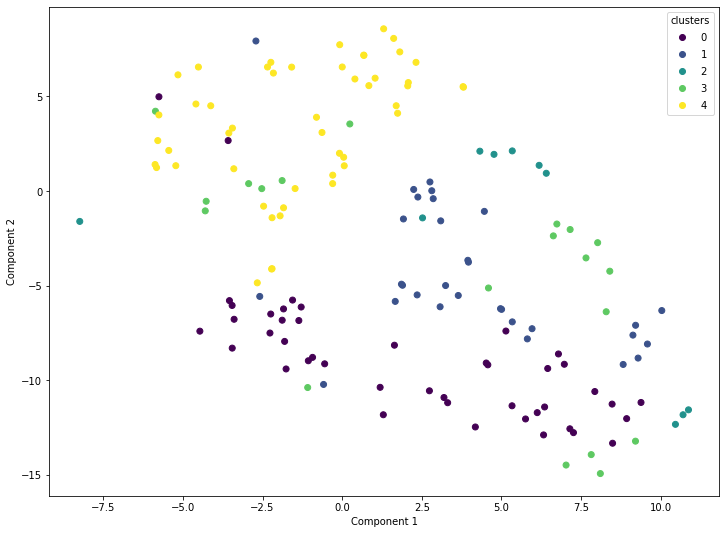

In [44]:
fig = plt.figure(figsize=(12, 9))
sc = plt.scatter(gow_tsne[:,0], gow_tsne[:,1], c=agglo_preds)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(*sc.legend_elements(), title='clusters')
plt.savefig(os.path.join(results_dir, 'gower_agglo_plot'))
plt.show()

In [45]:
summarize_clusters(agglo_data)

/Users/jmriiser/Dev/master_thesis/data_mining_prac/src/utils.py:95: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  [data.groupby(['Clusters']).get_group(i).median().T,
/Users/jmriiser/Dev/master_thesis/data_mining_prac/src/utils.py:95: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  [data.groupby(['Clusters']).get_group(i).median().T,
/Users/jmriiser/Dev/master_thesis/data_mining_prac/src/utils.py:95: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  [data.groupby(['Clusters']).get_group(i).m

,0,1,2,3,4
DMAGE,78.000,73.000,70.000,73.000,63.000
ECHIVSD,1.600,1.300,1.600,1.600,1.400
ECHLVPW,1.200,1.000,1.300,1.400,1.000
ECHLAAR,31.000,28.000,23.500,25.000,24.000
ECHEJFR,40.000,53.000,44.000,50.000,55.000
HEKRRE,108.000,92.500,98.000,112.000,83.000
HEGFRRE,64.000,68.500,53.000,57.000,76.000
HEBNPRE,2532.000,1203.500,4346.000,2603.500,1002.000
HETNTRE,61.000,23.000,61.500,57.000,25.500
Clusters,0.000,1.000,2.000,3.000,4.000


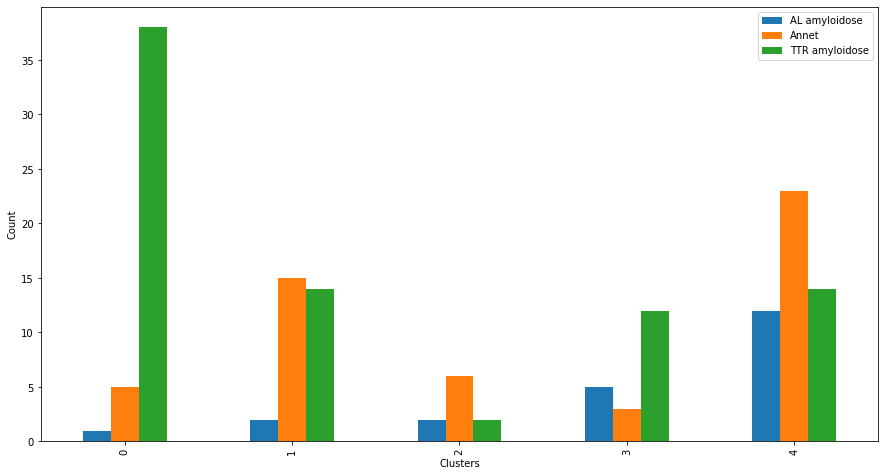

In [46]:
data = pd.DataFrame(agglo_data.groupby(['Clusters', 'PHDIAG']).size()).unstack(fill_value=0)
data.plot(kind='bar',figsize=(15, 8), xlabel='Clusters', ylabel='Count')
plt.legend(['AL amyloidose', 'Annet', 'TTR amyloidose'])
plt.savefig(os.path.join(results_dir, 'agglo_clusters'))

In [47]:
agglo_data.groupby(['Clusters', 'PHDIAG']).count().DMSEX, agglo_data.groupby(['Clusters', 'DPD']).count().DMSEX

(Clusters  PHDIAG        
 0         AL amyloidose      1
           Annet              5
           TTR amyloidose    38
 1         AL amyloidose      2
           Annet             15
           TTR amyloidose    14
 2         AL amyloidose      2
           Annet              6
           TTR amyloidose     2
 3         AL amyloidose      5
           Annet              3
           TTR amyloidose    12
 4         AL amyloidose     12
           Annet             23
           TTR amyloidose    14
 Name: DMSEX, dtype: int64,
 Clusters  DPD                  
 0         2.0                       8
           3.0                      17
           Ikke testet              12
           Normal                    2
           Patologisk, uten grad     5
 1         1.0                       6
           2.0                       3
           3.0                       5
           Ikke testet               2
           Normal                   13
           Patologisk, uten grad     2
 2  

In [48]:
agglo_data.groupby(['Clusters']).describe(include='object').T

Clusters                      0             1          2               3  \
DMSEX    count               44            31         10              20   
         unique               2             2          2               1   
         top               Mann          Mann     Kvinne            Mann   
         freq                42            22          7              20   
PHPERFYN count               44            31         10              20   
         unique               3             2          2               3   
         top                Nei           Nei        Nei              Ja   
         freq                21            26          5              10   
PHMH2    count               44            31         10              20   
         unique               2             2          1               2   
         top       Atrieflimmer  Atrieflimmer     Ukjent          Ukjent   
         freq                41            22         10              17   
PHMH6    count               44            31         10              20   
         unique               2             2          2               2   
         top             Ukjent        Ukjent     Ukjent          Ukjent   
         freq                24            22          7              16   
PHMH7    count               44            31         10              20   
         unique               2             2          1               2   
         top             Ukjent     Hypertoni  Hypertoni          Ukjent   
         freq                34            29         10              11   
EKGVOLT  count               44            31         10              20   
         unique               3             2          1               3   
         top                Nei           Nei        Nei              Ja   
         freq                30            28         10              10   
DPD      count               44            31         10              20   
         unique               5             6          3               5   
         top                3.0        Normal     Normal          Normal   
         freq                17            13          5               7   
PHDIAG   count               44            31         10              20   
         unique               3             3          3               3   
         top     TTR amyloidose         Annet      Annet  TTR amyloidose   
         freq                38            15          6              12   

Clusters              4  
DMSEX    count       49  
         unique       2  
         top       Mann  
         freq        26  
PHPERFYN count       49  
         unique       3  
         top        Nei  
         freq        40  
PHMH2    count       49  
         unique       2  
         top     Ukjent  
         freq        44  
PHMH6    count       49  
         unique       2  
         top     Ukjent  
         freq        39  
PHMH7    count       49  
         unique       1  
         top     Ukjent  
         freq        49  
EKGVOLT  count       49  
         unique       3  
         top        Nei  
         freq        46  
DPD      count       49  
         unique       4  
         top     Normal  
         freq        21  
PHDIAG   count       49  
         unique       3  
         top      Annet  
         freq        23

Validation scores

In [49]:
eval_external_metrics(agglo_data, y, y_ca, num_k)
eval_internal_metrics(gow_tsne, agglo_data.Clusters)

Accuracy Score: 0.610
Recall Score: 0.610
Precision Score: 0.571
F1 Score: 0.570
CA/non-CA
Accuracy Score : 0.675
Recall Score: 0.675
Precision Score: 0.653
F1 Score : 0.593
Silhouette Score: 0.161
Calinski Harabasz Score: 33.966
Davies Bouldin Score: 8.486


/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.16075242, 33.96603462999876, 8.485747508689842)

#### DBSCAN

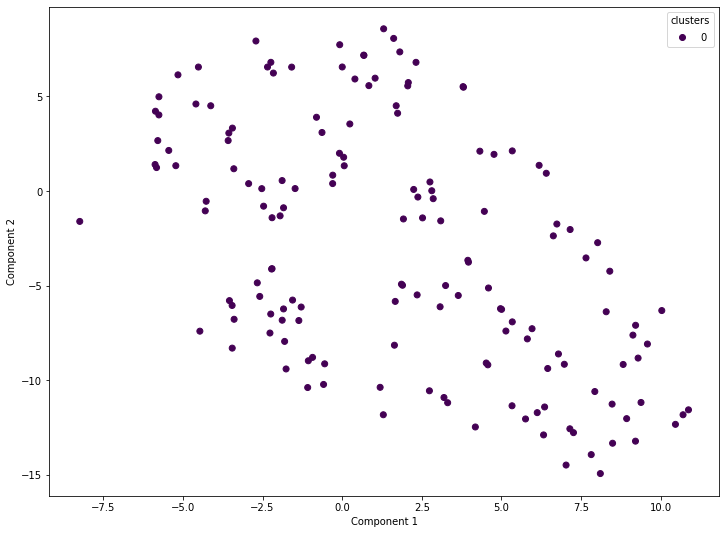

In [50]:
fig = plt.figure(figsize=(12, 9))
sc = plt.scatter(gow_tsne[:,0], gow_tsne[:,1], c=dbsc_preds)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(*sc.legend_elements(), title='clusters')
plt.savefig(os.path.join(results_dir, 'gower_dbscan_plot'))
plt.show()

#### OPTICS

In [51]:
optics_found = optics_data[optics_data.Clusters != -1]

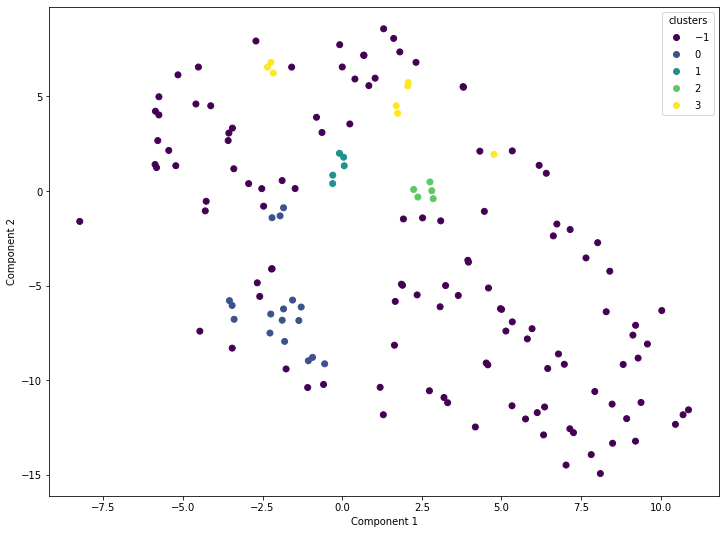

In [52]:
fig = plt.figure(figsize=(12, 9))
sc = plt.scatter(gow_tsne[:,0], gow_tsne[:,1], c=opt_preds)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(*sc.legend_elements(), title='clusters')
plt.savefig(os.path.join(results_dir, 'gower_optics_plot'))
plt.show()

In [53]:
optics_found.groupby(['Clusters']).describe(include='object').T

Clusters                      0       1          2       3
DMSEX    count               17       5          5       8
         unique               1       1          1       1
         top               Mann    Mann       Mann  Kvinne
         freq                17       5          5       8
PHPERFYN count               17       5          5       8
         unique               1       1          1       1
         top                Nei     Nei        Nei     Nei
         freq                17       5          5       8
PHMH2    count               17       5          5       8
         unique               2       1          1       1
         top       Atrieflimmer  Ukjent     Ukjent  Ukjent
         freq                14       5          5       8
PHMH6    count               17       5          5       8
         unique               1       1          1       2
         top             Ukjent  Ukjent     Ukjent  Ukjent
         freq                17       5          5       5
PHMH7    count               17       5          5       8
         unique               1       1          1       2
         top             Ukjent  Ukjent  Hypertoni  Ukjent
         freq                17       5          5       7
EKGVOLT  count               17       5          5       8
         unique               2       1          1       1
         top                Nei     Nei        Nei     Nei
         freq                14       5          5       8
DPD      count               17       5          5       8
         unique               2       1          1       1
         top                3.0  Normal     Normal  Normal
         freq                14       5          5       8
PHDIAG   count               17       5          5       8
         unique               2       2          2       1
         top     TTR amyloidose   Annet      Annet   Annet
         freq                16       4          4       8

In [54]:
summarize_clusters(optics_found)

/Users/jmriiser/Dev/master_thesis/data_mining_prac/src/utils.py:95: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  [data.groupby(['Clusters']).get_group(i).median().T,
/Users/jmriiser/Dev/master_thesis/data_mining_prac/src/utils.py:95: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  [data.groupby(['Clusters']).get_group(i).median().T,
/Users/jmriiser/Dev/master_thesis/data_mining_prac/src/utils.py:95: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  [data.groupby(['Clusters']).get_group(i).m

,0,1,2,3
DMAGE,76.000,55.000,58.000,66.500
ECHIVSD,1.800,1.150,1.200,2.000
ECHLVPW,1.050,0.900,1.000,1.300
ECHLAAR,31.500,26.000,23.000,22.000
ECHEJFR,42.500,NaN,50.000,55.500
HEKRRE,91.000,80.000,86.000,93.000
HEGFRRE,68.000,96.000,84.000,56.000
HEBNPRE,1943.000,409.000,191.000,967.000
HETNTRE,53.500,17.000,7.000,17.000
Clusters,0.000,1.000,2.000,3.000


In [55]:
optics_found.groupby(['Clusters', 'PHDIAG']).count().DMSEX

Clusters  PHDIAG        
0         Annet              1
          TTR amyloidose    16
1         AL amyloidose      1
          Annet              4
2         AL amyloidose      1
          Annet              4
3         Annet              8
Name: DMSEX, dtype: int64

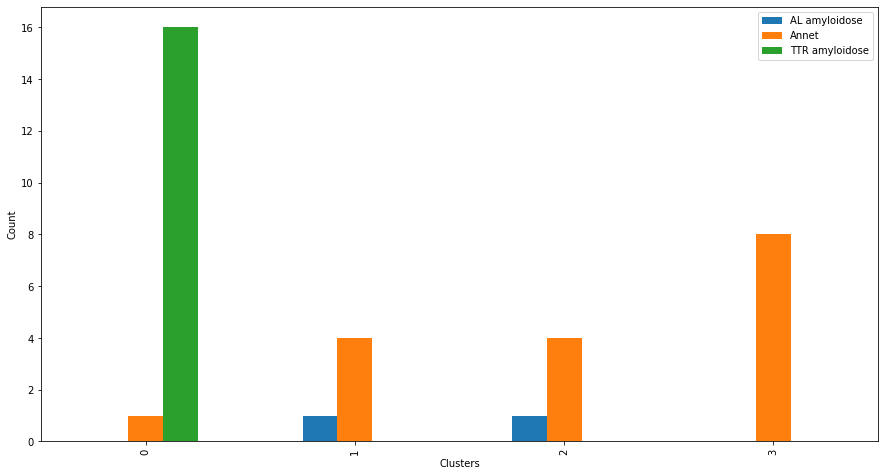

In [56]:
data = pd.DataFrame(optics_found.groupby(['Clusters', 'PHDIAG']).size()).unstack(fill_value=0)
data.plot(kind='bar',figsize=(15, 8), xlabel='Clusters', ylabel='Count')
plt.legend(['AL amyloidose', 'Annet', 'TTR amyloidose'])
plt.savefig(os.path.join(results_dir, 'optics_clusters'))

In [57]:
optics_found.groupby(['Clusters']).describe(include='object').T

Clusters                      0       1          2       3
DMSEX    count               17       5          5       8
         unique               1       1          1       1
         top               Mann    Mann       Mann  Kvinne
         freq                17       5          5       8
PHPERFYN count               17       5          5       8
         unique               1       1          1       1
         top                Nei     Nei        Nei     Nei
         freq                17       5          5       8
PHMH2    count               17       5          5       8
         unique               2       1          1       1
         top       Atrieflimmer  Ukjent     Ukjent  Ukjent
         freq                14       5          5       8
PHMH6    count               17       5          5       8
         unique               1       1          1       2
         top             Ukjent  Ukjent     Ukjent  Ukjent
         freq                17       5          5       5
PHMH7    count               17       5          5       8
         unique               1       1          1       2
         top             Ukjent  Ukjent  Hypertoni  Ukjent
         freq                17       5          5       7
EKGVOLT  count               17       5          5       8
         unique               2       1          1       1
         top                Nei     Nei        Nei     Nei
         freq                14       5          5       8
DPD      count               17       5          5       8
         unique               2       1          1       1
         top                3.0  Normal     Normal  Normal
         freq                14       5          5       8
PHDIAG   count               17       5          5       8
         unique               2       2          2       1
         top     TTR amyloidose   Annet      Annet   Annet
         freq                16       4          4       8

In [58]:
summarize_clusters(optics_found)

/Users/jmriiser/Dev/master_thesis/data_mining_prac/src/utils.py:95: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  [data.groupby(['Clusters']).get_group(i).median().T,
/Users/jmriiser/Dev/master_thesis/data_mining_prac/src/utils.py:95: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  [data.groupby(['Clusters']).get_group(i).median().T,
/Users/jmriiser/Dev/master_thesis/data_mining_prac/src/utils.py:95: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  [data.groupby(['Clusters']).get_group(i).m

,0,1,2,3
DMAGE,76.000,55.000,58.000,66.500
ECHIVSD,1.800,1.150,1.200,2.000
ECHLVPW,1.050,0.900,1.000,1.300
ECHLAAR,31.500,26.000,23.000,22.000
ECHEJFR,42.500,NaN,50.000,55.500
HEKRRE,91.000,80.000,86.000,93.000
HEGFRRE,68.000,96.000,84.000,56.000
HEBNPRE,1943.000,409.000,191.000,967.000
HETNTRE,53.500,17.000,7.000,17.000
Clusters,0.000,1.000,2.000,3.000


Validation scores

In [59]:
eval_external_metrics(optics_found, y[y.index.isin(optics_found.index)], y_ca[y_ca.index.isin(optics_found.index)], num_k)
eval_internal_metrics(gow_tsne[y.index.isin(optics_found.index)], optics_found.Clusters)

Accuracy Score: 0.914
Recall Score: 0.914
Precision Score: 0.862
F1 Score: 0.887
CA/non-CA
Accuracy Score : 0.914
Recall Score: 0.914
Precision Score: 0.916
F1 Score : 0.914
Silhouette Score: 0.500
Calinski Harabasz Score: 47.660
Davies Bouldin Score: 0.626


/Users/jmriiser/Dev/master_thesis/data_mining_prac/src/eval_metrics.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['c2c'] = data['Clusters'].map(c2c)
/Users/jmriiser/Dev/master_thesis/data_mining_prac/src/eval_metrics.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['c2c_binary'] = data['Clusters'].map(c2c_binary)
/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predi

(0.5004872, 47.6601203354434, 0.6259007431526169)

### Ignore below

In [60]:
def clusters_to_classes(grouping, num_clusters):
    mapping = {}
    for i in range(num_clusters):
        if i in grouping.Clusters.unique():
            mapping[i] = grouping['PHDIAG'].count()[i].idxmax()
    return mapping


def clusters_to_binary(grouping, num_clusters):
    mapping = {}
    for i in range(num_clusters):
        if i in grouping.Clusters.unique():
            filt = mapping[i] = grouping['PHDIAG'].count()[i]
            ca = filt[filt.index != 'Annet'].sum()
            non = filt[filt.index == 'Annet'].sum()

            mapping[i] = 'non-CA' if ca < non else 'CA'

    return mapping

In [61]:
clusters_to_classes(kproto_test.groupby(['Clusters', 'PHDIAG']), num_k)

{0: 'Annet', 2: 'TTR amyloidose', 3: 'TTR amyloidose', 4: 'AL amyloidose'}

In [62]:
clusters_to_binary(kproto_test.groupby(['Clusters', 'PHDIAG']), num_k)

{0: 'CA', 2: 'CA', 3: 'CA', 4: 'CA'}